# Data Cleaning and Feature Engineering

## Import Data

In [2]:
import pandas as pd
import numpy as np

In [3]:
# Import data

#Import train data
train_data_url = 'https://raw.githubusercontent.com/cal-dortiz/W207_Applied-_Machine_Learning/main/Final_Project/Data/train.csv'
df_train = pd.read_csv(train_data_url)

#Import test data
#test_data_url = 'https://raw.githubusercontent.com/cal-dortiz/W207_Applied-_Machine_Learning/main/Final_Project/Data/test.csv'
#df_test = pd.read_csv(test_data_url)

## Data Cleaning

### Data Removal

Based on the exploritory data analysis, attributes that have a high amount of missing data and low impact shall be removed from the data set.

In [4]:
df_train = df_train.drop(columns=['PoolQC','MiscFeature','Alley','Fence','Id'])

### Cleaning Housing SqFt

The EDA confirms the assumption that larger houses are correlated to highter prices. This section reviews all attributes that measure the size of the house.

The basement area is not counted as basesments may not be used in assessing property value. The correlation between 'TotalBsmtSF' and price may be due to the correlation of the size of the foundation to the size of the first floor. Keeping 'TotalBsmtSF' in the model may lead to colinearity.

In [5]:
# Removal of 'TotalBsmtSf'
df_train = df_train.drop(columns=['TotalBsmtSF'])

Since square-footage of the house is highly correlated to its price, lets calculate

The data set breaks sqft and room data into basement, first floor, and seccond floor. We believe combining first and second floor room and sqft data into a single dimension will reduce the risk of colineiarity of two attributes being in the model and increase the power of the attribute.

We will leave the basement data seperate as we do not understand if the basement attributes are allowed to be used in housing assessments.

In [6]:
# Combine SqFt
df_train['TotSqFt'] = df_train['1stFlrSF'] + df_train['2ndFlrSF']
df_train = df_train.drop(columns=['1stFlrSF','2ndFlrSF'])

In [7]:
df_train.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'Heating', 'HeatingQC', 'CentralAir',
       'Electrical', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3Ssn

In [8]:
#Describe numerical variables
NumDataSet = df_train.select_dtypes(exclude='O')
#Describe categorical variables
CatDataSet = df_train.select_dtypes(include='O')
Categorical_Cols = CatDataSet.columns.tolist()
Categorical_Cols

Numerical_Cols = NumDataSet.columns.tolist()
Numerical_Cols 
#Within categorical variables, there are several categories that are not 
#purely nominal/unordered but insteted are ordered categories - In other
#words, they are ordinal but have text values, not numerical values. We separate
#these into a new category
Ordered_Category = CatDataSet[['ExterQual','ExterCond','BsmtQual','BsmtCond',
                   'HeatingQC','KitchenQual','FireplaceQu','GarageQual','GarageCond']].copy()
for i in Ordered_Category:
    print(Ordered_Category[i].value_counts())
    
#Remove these columns from the categorical dataset, which will now include only
#unordered categories
CatDataSet = CatDataSet.drop(['ExterQual','ExterCond','BsmtQual','BsmtCond', 'HeatingQC','KitchenQual','FireplaceQu','GarageQual','GarageCond'], axis = 'columns')


#4.2.2 Convert all cateogrical values to numeric values
#For ordered category data, use the ordinal encoder from sklearn.
#Given a dataset with unique features, we let the encoder find the unique values per feature and transform the data to an ordinal encoding.
Ordered_Category['ExterQual'].replace(to_replace=['Ex', 'Gd', 'TA', 'Fa', 'Po', np.nan], value=[5, 4, 3, 2, 1, 0], inplace=True)
Ordered_Category['ExterCond'].replace(to_replace=['Ex', 'Gd', 'TA', 'Fa', 'Po', np.nan], value=[5, 4, 3, 2, 1, 0], inplace=True)
Ordered_Category['BsmtQual'].replace(to_replace=['Ex', 'Gd', 'TA', 'Fa', 'Po', np.nan], value=[5, 4, 3, 2, 1, 0], inplace=True)
Ordered_Category['BsmtCond'].replace(to_replace=['Ex', 'Gd', 'TA', 'Fa', 'Po', np.nan], value=[5, 4, 3, 2, 1, 0], inplace=True)
Ordered_Category['HeatingQC'].replace(to_replace=['Ex', 'Gd', 'TA', 'Fa', 'Po', np.nan], value=[5, 4, 3, 2, 1, 0], inplace=True)
Ordered_Category['KitchenQual'].replace(to_replace=['Ex', 'Gd', 'TA', 'Fa', 'Po', np.nan], value=[5, 4, 3, 2, 1, 0], inplace=True)
Ordered_Category['FireplaceQu'].replace(to_replace=['Ex', 'Gd', 'TA', 'Fa', 'Po', np.nan], value=[5, 4, 3, 2, 1, 0], inplace=True)
Ordered_Category['GarageQual'].replace(to_replace=['Ex', 'Gd', 'TA', 'Fa', 'Po', np.nan], value=[5, 4, 3, 2, 1, 0], inplace=True)
Ordered_Category['GarageCond'].replace(to_replace=['Ex', 'Gd', 'TA', 'Fa', 'Po', np.nan], value=[5, 4, 3, 2, 1, 0], inplace=True)
NumDataSet['GarageYrBlt'].replace(to_replace=[np.nan], value=[0], inplace=True)
NumDataSet['LotFrontage'].replace(to_replace=[np.nan], value=[0], inplace=True)
NumDataSet['MasVnrArea'].replace(to_replace=[np.nan], value=[0], inplace=True)


TA    906
Gd    488
Ex     52
Fa     14
Name: ExterQual, dtype: int64
TA    1282
Gd     146
Fa      28
Ex       3
Po       1
Name: ExterCond, dtype: int64
TA    649
Gd    618
Ex    121
Fa     35
Name: BsmtQual, dtype: int64
TA    1311
Gd      65
Fa      45
Po       2
Name: BsmtCond, dtype: int64
Ex    741
TA    428
Gd    241
Fa     49
Po      1
Name: HeatingQC, dtype: int64
TA    735
Gd    586
Ex    100
Fa     39
Name: KitchenQual, dtype: int64
Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: FireplaceQu, dtype: int64
TA    1311
Fa      48
Gd      14
Ex       3
Po       3
Name: GarageQual, dtype: int64
TA    1326
Fa      35
Gd       9
Po       7
Ex       2
Name: GarageCond, dtype: int64


C:\Users\djwei\Anaconda3\lib\site-packages\pandas\core\generic.py:6586: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [19]:
#Import LabelEncoder to code categorical variables
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [21]:
#For categorical data, use LabelEncoder to categorize the variables.
for col in CatDataSet:
    i = CatDataSet.columns.get_loc(col)
    CatDataSet.iloc[:,i] = CatDataSet.apply(lambda i:le.fit_transform(i.astype(str)), axis=0, result_type='expand')

In [22]:
# glue data sets together
df_train2 = pd.concat((CatDataSet, Ordered_Category, NumDataSet), axis=1, join='inner')

In [23]:
#See if there are any nulls left.
df_train2.isnull().sum().sort_values(ascending = False).head(20)

TotSqFt          0
BsmtExposure     0
BsmtFinType2     0
Heating          0
CentralAir       0
Electrical       0
Functional       0
GarageType       0
GarageFinish     0
PavedDrive       0
SaleType         0
SaleCondition    0
ExterQual        0
ExterCond        0
BsmtQual         0
BsmtCond         0
HeatingQC        0
BsmtFinType1     0
Foundation       0
SalePrice        0
dtype: int64

In [24]:
#Show a correlation matrix with numbers
corrs = df_train2.corr('spearman')['SalePrice'].sort_values(ascending = False)

corrs_abs = corrs.abs()
sortedSeries = corrs_abs.sort_values(ascending=False)
print(sortedSeries.head(100))


SalePrice        1.000000
OverallQual      0.809829
TotSqFt          0.738046
GrLivArea        0.731310
GarageCars       0.690711
BsmtQual         0.678026
YearBuilt        0.652682
GarageArea       0.649379
FullBath         0.635957
GarageYrBlt      0.634095
GarageFinish     0.633974
YearRemodAdd     0.571159
FireplaceQu      0.537602
TotRmsAbvGrd     0.532586
Fireplaces       0.519247
GarageType       0.517990
Foundation       0.491932
OpenPorchSF      0.477561
LotArea          0.456461
MasVnrArea       0.415906
WoodDeckSF       0.353802
GarageQual       0.351082
HalfBath         0.343008
GarageCond       0.339015
MSZoning         0.334909
BsmtExposure     0.320961
SaleCondition    0.319667
CentralAir       0.313286
LotShape         0.305923
BsmtFinSF1       0.301871
                   ...   
SaleType         0.176306
Neighborhood     0.165609
KitchenAbvGr     0.164826
RoofStyle        0.140164
Functional       0.135267
OverallCond      0.129325
BldgType         0.119934
Heating     

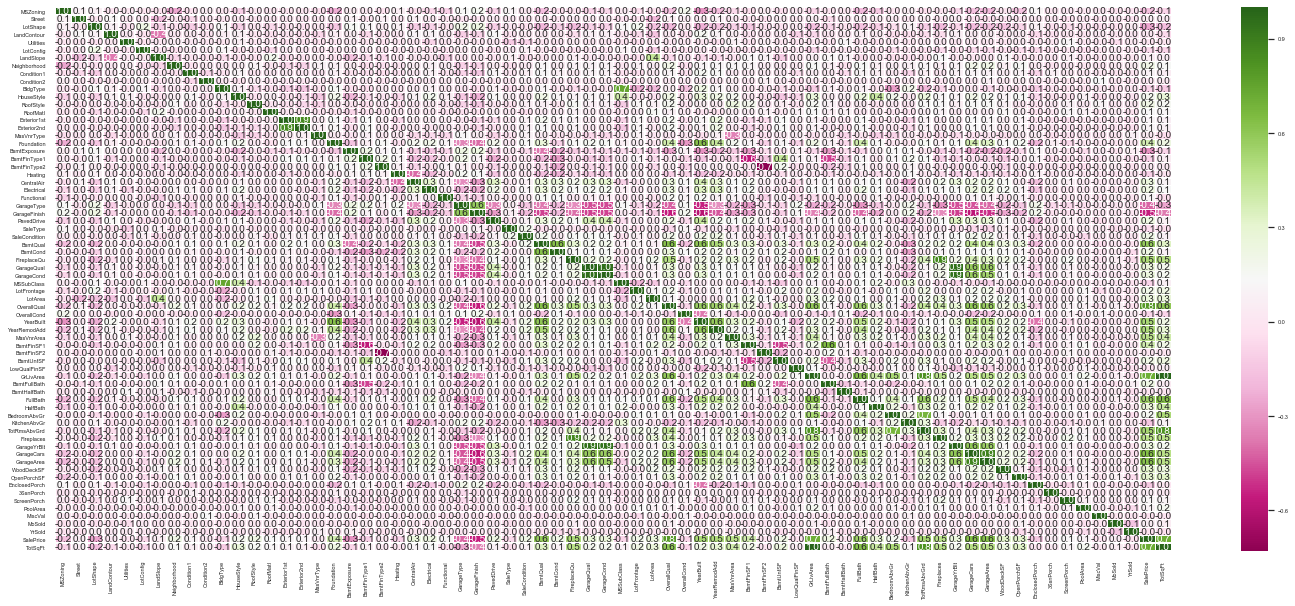

In [31]:
#View a correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt
correlation_train = df_train2.corr()
sns.set(font_scale=0.5)
plt.figure(figsize=(25, 10))
ax = sns.heatmap(correlation_train, annot=True, annot_kws={'size': 10}, fmt='.1f', cmap='PiYG', linewidths=.2)
plt.show()